In [1]:
import json
import matplotlib.pyplot as plt
import random 
import requests
import time
import uuid
import datetime

# Personalizer 리소스 키 및 이름 설정
* Personalizer 리소스에 대한 Azure Portal의 빠른 시작 페이지에서 키와 엔드포인트를 찾습니다. 
* "your-resource-name" 값을 Personalizer 리소스의 이름으로 변경합니다. "your-resource-key" 값을 Personalizer 키로 변경합니다.

In [12]:
# Replace 'personalization_base_url' and 'resource_key' with your valid endpoint values.
personalization_base_url = "https://recommend-coffee-01.cognitiveservices.azure.com/"
resource_key = "f7e7d563638542ccaf46c455a662f058"

# Print current data and time

In [3]:
# Print out current datetime
def currentDateTime():
    currentDT = datetime.datetime.now()
    print (str(currentDT))

In [5]:
currentDateTime()

2021-08-10 10:47:47.690268


# Get the last model update date and time

In [8]:
# ititialize variable for model's last modified date
modelLastModified = ""

In [4]:
def get_last_updated(currentModifiedDate):
    
    print('-----checking model')
    
    # get model properties
    response = requests.get(personalization_model_properties_url, headers = headers, params = None)
    
    print(response)
    print(response.json())
    
    # get lastModifiedTime
    lastModifiedTime = json.dumps(response.json()["lastModifiedTime"])
    
    if (currentModifiedDate != lastModifiedTime):
        currentModifiedDate = lastModifiedTime
        print(f'-----model updated: {lastModifiedTime}')

# Get policy and service configruation

In [5]:
def get_service_settings():
    
    print('-----checking service settings')
    
    # get learning policy
    response = requests.get(personalization_model_policy_url, headers = headers, params = None)
    
    print(response)
    print(response.json())
    
    # get service settings
    response = requests.get(personalization_service_configuration_url, headers = headers, params = None)
    
    print(response)
    print(response.json())

# URL 생성 및 JSON 데이터 파일 읽기

* 이 셀에서 다음을 수행합니다.
    * REST 호출에 사용되는 URL을 작성합니다.
    * Personalizer 리소스 키를 사용하여 보안 헤더를 설정합니다.
    * 순위 이벤트 ID의 임의 시드를 설정합니다.
    * JSON 데이터 파일을 읽습니다.
    * get_last_updated 메서드를 호출합니다. 예제 출력에서 학습 정책이 제거됩니다.
    * get_service_settings 메서드를 호출합니다.

In [13]:
# build URLs
personalization_rank_url = personalization_base_url + "personalizer/v1.0/rank"
personalization_reward_url = personalization_base_url + "personalizer/v1.0/events/" #add "{eventId}/reward"
personalization_model_properties_url = personalization_base_url + "personalizer/v1.0/model/properties"
personalization_model_policy_url = personalization_base_url + "personalizer/v1.0/configurations/policy"
personalization_service_configuration_url = personalization_base_url + "personalizer/v1.0/configurations/service"
headers = {'Ocp-Apim-Subscription-Key' : resource_key, 'Content-Type': 'application/json'}

# context
users = "demo_data/users.json"

# action features
coffee = "demo_data/coffee.json"

# empty JSON for Rank request
requestpath = "demo_data/example-rankrequest.json"

# initialize random
random.seed(time.time())

userpref = None 
rankactionsjsonobj = None 
actionfeaturesobj = None

with open(users) as handle:
    userpref = json.loads(handle.read())

with open(coffee) as handle:
    actionfeaturesobj = json.loads(handle.read())
    
with open(requestpath) as handle:
    rankactionsjsonobj = json.loads(handle.read())  
    
get_last_updated(modelLastModified)
get_service_settings()

print(f'User count {len(userpref)}')
print(f'Coffee count {len(actionfeaturesobj)}')

-----checking model
<Response [200]>
{'creationTime': '2021-08-09T23:03:09+00:00', 'lastModifiedTime': '2021-08-09T23:03:09+00:00'}
-----model updated: "2021-08-09T23:03:09+00:00"
-----checking service settings
<Response [200]>
{'name': '83ef3a84273c4a6cae94432a01f87521', 'arguments': '--cb_explore_adf --epsilon 0.20000000298023224 --power_t 0 -l 0.001 --cb_type mtr -q ::'}
<Response [200]>
{'rewardWaitTime': 'PT10M', 'defaultReward': 0.0, 'rewardAggregation': 'earliest', 'explorationPercentage': 0.2, 'modelExportFrequency': 'PT1H', 'logRetentionDays': 90, 'lastConfigurationEditDate': '0001-01-01T00:00:00', 'learningMode': 'Online'}
User count 4
Coffee count 4


# 고유 이벤트 ID 생성
* 이 함수는 각 순위 호출에 대한 고유 ID를 생성합니다. 
* ID는 순위 및 보상 호출 정보를 식별하는 데 사용됩니다. 이 값은 웹 보기 ID 또는 트랜잭션 ID와 같은 비즈니스 프로세스에서 가져올 수 있습니다.
* 셀에는 출력이 없습니다. 이 함수가 호출되면 고유 ID를 출력합니다.

In [14]:
def add_event_id(rankjsonobj):
    eventid = uuid.uuid4().hex
    rankjsonobj["eventId"] = eventid
    return eventid

# 임의 사용자, 날씨 및 하루 중 시간 가져오기

In [16]:
def add_random_user_and_contextfeatures(namesoption, weatheropt, timeofdayopt, rankjsonobj):
    name = namesoption[random.randint(0,3)]
    weather = weatheropt[random.randint(0,2)]
    timeofday = timeofdayopt[random.randint(0,2)]
    rankjsonobj['contextFeatures'] = [{'timeofday': timeofday, 'weather': weather, 'name': name}]
    return [name, weather, timeofday]

# 모든 커피 데이터 추가

In [18]:
def add_action_features(rankjsonobj):
    rankjsonobj["actions"] = actionfeaturesobj

# Compare Rank API's prediction with known user preference
* 각 반복에 대해 순위 API 호출이 호출되면 이 함수가 호출됩니다.
* 이 함수는 날씨와 시간을 기준으로 커피에 대한 사용자의 기본 설정을 해당 필터에 대한 사용자의 Personalizer 제안과 비교합니다. 
* 제안이 일치하면 1의 점수가 반환되고, 그렇지 않으면 점수가 0입니다. 
* 셀에는 출력이 없습니다. 이 함수가 호출되면 점수를 출력합니다.

In [19]:
def get_reward_from_simulated_data(name, weather, timeofday, prediction):
    if(userpref[name][weather][timeofday] == str(prediction)):
        return 1
    return 0

# Loop through calls to Rank and Reward
* 다음 셀은 임의의 사용자를 가져오고, 커피 목록을 가져오며, 둘 모두를 순위 API에 보내는 Notebook의 main 작업입니다. 
* 예측과 사용자의 알려진 기본 설정을 비교한 다음, 보상을 Personalizer 서비스에 다시 보냅니다.
* 루프는 num_requests회 실행됩니다. Personalizer에서 모델을 만들려면 순위 및 보상에 대한 수천 개의 호출이 필요합니다.
* 순위 API에 보내는 JSON의 예제는 다음과 같습니다. 간단히 하기 위해 커피 목록이 완전하지 않습니다. coffee.json에서 커피의 전체 JSON을 볼 수 있습니다.

In [24]:
def iterations(n, modelCheck, jsonFormat):

    i = 1

    # default reward value - assumes failed prediction
    reward = 0

    # Print out dateTime
    currentDateTime()

    # collect results to aggregate in graph
    total = 0
    rewards = []
    count = []

    # default list of user, weather, time of day
    namesopt = ['Alice', 'Bob', 'Cathy', 'Dave']
    weatheropt = ['Sunny', 'Rainy', 'Snowy']
    timeofdayopt = ['Morning', 'Afternoon', 'Evening']


    while(i <= n):

        # create unique id to associate with an event
        eventid = add_event_id(jsonFormat)

        # generate a random sample
        [name, weather, timeofday] = add_random_user_and_contextfeatures(namesopt, weatheropt, timeofdayopt, jsonFormat)

        # add action features to rank
        add_action_features(jsonFormat)

        # show JSON to send to Rank
        print('To: ', jsonFormat)

        # choose an action - get prediction from Personalizer
        response = requests.post(personalization_rank_url, headers = headers, params = None, json = jsonFormat)

        # show Rank prediction
        print ('From: ',response.json())

        # compare personalization service recommendation with the simulated data to generate a reward value
        prediction = json.dumps(response.json()["rewardActionId"]).replace('"','')
        reward = get_reward_from_simulated_data(name, weather, timeofday, prediction)

        # show result for iteration
        print(f'   {i} {currentDateTime()} {name} {weather} {timeofday} {prediction} {reward}')

        # send the reward to the service
        response = requests.post(personalization_reward_url + eventid + "/reward", headers = headers, params= None, json = { "value" : reward })

        # for every N rank requests, compute total correct  total
        total =  total + reward

        # every N iteration, get last updated model date and time
        if(i % modelCheck == 0):

            print("**** 10% of loop found")

            get_last_updated(modelLastModified)

        # aggregate so chart is easier to read
        if(i % 10 == 0):
            rewards.append( total)
            count.append(i)
            total = 0

        i = i + 1

    # Print out dateTime
    currentDateTime()

    return [count, rewards]

In [25]:
# max iterations
num_requests = 200

# check last mod date N% of time - currently 10%
lastModCheck = int(num_requests * .10)

jsonTemplate = rankactionsjsonobj

# main iterations
[count, rewards] = iterations(num_requests, lastModCheck, jsonTemplate)

2021-08-10 13:21:14.009265
To:  {'contextFeatures': [{'timeofday': 'Evening', 'weather': 'Rainy', 'name': 'Dave'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '2ab689ad506f4f42b7ddc2557d66df89', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': '2ab689ad506f4f42b7ddc2557d66df89', 'rewardActionId': 'Cold brew'}
2021-08-10 13:21:15.442224
   1 None Dave Rainy Evening Cold brew 0
To:  {'contextF

From:  {'ranking': [{'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'cf8920732e394704b439e6f34d1ed879', 'rewardActionId': 'Cold brew'}
2021-08-10 13:21:32.911791
   9 None Bob Rainy Evening Cold brew 0
To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Snowy', 'name': 'Cathy'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': 'f03e64a79c7146d4b7f52dcab5a3ed05', 'deferActivation': False}
From:  {'ranking': [{'id': 'Iced mocha', '

From:  {'ranking': [{'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'ab1436902fea49b8a38541e9f9d98562', 'rewardActionId': 'Cold brew'}
2021-08-10 13:21:48.146090
   18 None Dave Snowy Evening Cold brew 0
To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Sunny', 'name': 'Bob'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': 'c7090e1572af494691007a97029893a7', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cappucino', 

To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Rainy', 'name': 'Alice'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': 'e1c05caffbbc416f98bb037830de94ab', 'deferActivation': False}
From:  {'ranking': [{'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'e1c05caffbbc416f98bb037830de94ab', 'rewardActionId': 'Iced mocha'}
2021-08-10 13:22:04.229061
   27 None Alice Rainy Afternoon Iced mocha 0
To:  {'contextFeatures': [{'timeo

From:  {'ranking': [{'id': 'Latte', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}], 'eventId': 'a199cec9406a4ce5abee8077d786af17', 'rewardActionId': 'Latte'}
2021-08-10 13:22:17.398370
   35 None Cathy Rainy Morning Latte 0
To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Snowy', 'name': 'Alice'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': 'cecf3182b40e4206b2c9b0f48dc3edbc', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cold brew', 'prob

To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Snowy', 'name': 'Dave'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': 'c29c5ca4f8cf4dfe9a0cd3190d7623a4', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'c29c5ca4f8cf4dfe9a0cd3190d7623a4', 'rewardActionId': 'Cold brew'}
2021-08-10 13:22:33.702445
   44 None Dave Snowy Morning Cold brew 0
To:  {'contextFeatures': [{'timeofday': '

From:  {'ranking': [{'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'b43d8ff11abb436e96216f7c4201420a', 'rewardActionId': 'Iced mocha'}
2021-08-10 13:22:48.993705
   52 None Alice Sunny Morning Iced mocha 0
To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Snowy', 'name': 'Bob'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '9a28ed606e704b51afe4501ea1225127', 'deferActivation': False}
From:  {'ranking': [{'id': 'Iced moch

From:  {'ranking': [{'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': '9a5453548f3f4537a843d4871a7120d3', 'rewardActionId': 'Iced mocha'}
2021-08-10 13:23:04.846083
   61 None Alice Sunny Morning Iced mocha 0
To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Sunny', 'name': 'Bob'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '4d80da71bfd84ddda1dc4a3b10c62f44', 'deferActivation': False}
From:  {'ranking': [{'id': 'Iced mocha'

From:  {'ranking': [{'id': 'Latte', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}], 'eventId': '2f0357ea6291473a8498f6b87cc72cff', 'rewardActionId': 'Latte'}
2021-08-10 13:23:20.213640
   70 None Cathy Sunny Afternoon Latte 0
To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Rainy', 'name': 'Alice'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': 'c48f759f402945a68590a3a07e963a5f', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cappucino', 'pr

From:  {'ranking': [{'id': 'Cappucino', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'd6127b3eb92c42d8869684f403e54f08', 'rewardActionId': 'Cappucino'}
2021-08-10 13:23:35.289704
   79 None Bob Rainy Afternoon Cappucino 0
To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Snowy', 'name': 'Alice'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': 'fbc30dfad19a479db5bf0a9494a7fb37', 'deferActivation': False}
From:  {'ranking': [{'id': 'Iced moch

To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Sunny', 'name': 'Dave'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': 'f43641acd0c84b7a90af95dc85a2a362', 'deferActivation': False}
From:  {'ranking': [{'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'f43641acd0c84b7a90af95dc85a2a362', 'rewardActionId': 'Iced mocha'}
2021-08-10 13:23:51.344307
   88 None Dave Sunny Afternoon Iced mocha 1
To:  {'contextFeatures': [{'timeofd

From:  {'ranking': [{'id': 'Latte', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}], 'eventId': '0024cbb4f2a64428bb4ac6519b0422d0', 'rewardActionId': 'Latte'}
2021-08-10 13:24:05.173641
   96 None Dave Sunny Morning Latte 0
To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Sunny', 'name': 'Bob'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '4b3d8082039d40508f70a41beb55e302', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cold brew', 'probabi

To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Snowy', 'name': 'Alice'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '6da23496d350426abbd801d1b7bb6085', 'deferActivation': False}
From:  {'ranking': [{'id': 'Latte', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}], 'eventId': '6da23496d350426abbd801d1b7bb6085', 'rewardActionId': 'Latte'}
2021-08-10 13:24:21.553391
   105 None Alice Snowy Afternoon Latte 0
To:  {'contextFeatures': [{'timeofday': 'A

From:  {'ranking': [{'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': '5ae1271725c946448215202df4b864ec', 'rewardActionId': 'Cold brew'}
2021-08-10 13:24:35.453938
   113 None Alice Sunny Afternoon Cold brew 0
To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Sunny', 'name': 'Dave'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': 'e2680794f36c4bdbb77d00f3ae1f0b2a', 'deferActivation': False}
From:  {'ranking': [{'id': 'Latte', '

To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Rainy', 'name': 'Alice'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': 'd44760754c434152b5d2471cabec4511', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'd44760754c434152b5d2471cabec4511', 'rewardActionId': 'Cold brew'}
2021-08-10 13:24:51.467570
   122 None Alice Rainy Afternoon Cold brew 0
To:  {'contextFeatures': [{'timeof

From:  {'ranking': [{'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': '75cbbe33950b45ebb47dce18925674ce', 'rewardActionId': 'Cold brew'}
2021-08-10 13:25:05.492783
   130 None Alice Sunny Morning Cold brew 1
To:  {'contextFeatures': [{'timeofday': 'Evening', 'weather': 'Sunny', 'name': 'Alice'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': 'f8d8de50ee6b43e4aa2111bc7ecee3e7', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cold brew'

From:  {'ranking': [{'id': 'Latte', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}], 'eventId': '97543ee2cbf54198b2d4e50d1f25f44f', 'rewardActionId': 'Latte'}
2021-08-10 13:25:20.725519
   139 None Cathy Snowy Evening Latte 0
To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Sunny', 'name': 'Alice'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '450f74392052462cab0265537fa75526', 'deferActivation': False}
From:  {'ranking': [{'id': 'Latte', 'probabili

From:  {'ranking': [{'id': 'Cappucino', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': '9bb5769302b64fcbb6ef1ba26dbdfb6a', 'rewardActionId': 'Cappucino'}
2021-08-10 13:25:36.614494
   148 None Cathy Sunny Morning Cappucino 0
To:  {'contextFeatures': [{'timeofday': 'Evening', 'weather': 'Sunny', 'name': 'Alice'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '508639f0102d4a84862d72b70c486346', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cold brew'

From:  {'ranking': [{'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'dd38169de1bd4a53aabe5cee0760fe9d', 'rewardActionId': 'Cold brew'}
2021-08-10 13:25:52.847815
   157 None Cathy Snowy Morning Cold brew 1
To:  {'contextFeatures': [{'timeofday': 'Evening', 'weather': 'Snowy', 'name': 'Alice'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '525708a039584d1a9782b377172a4a1e', 'deferActivation': False}
From:  {'ranking': [{'id': 'Latte', 'p

To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Rainy', 'name': 'Alice'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '4552c617092c4161b9260a52d25ab786', 'deferActivation': False}
From:  {'ranking': [{'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': '4552c617092c4161b9260a52d25ab786', 'rewardActionId': 'Iced mocha'}
2021-08-10 13:26:08.832069
   166 None Alice Rainy Morning Iced mocha 0
To:  {'contextFeatures': [{'timeofda

From:  {'ranking': [{'id': 'Cappucino', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'f6a7f371853a47e59122eeeb41657dd7', 'rewardActionId': 'Cappucino'}
2021-08-10 13:26:22.394768
   174 None Cathy Sunny Morning Cappucino 0
To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Rainy', 'name': 'Bob'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '1e323e48d77a49fdbb251e88e0dea84e', 'deferActivation': False}
From:  {'ranking': [{'id': 'Latte', 'pro

To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Snowy', 'name': 'Cathy'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '203f9249f601455c823b56fdf00c2b4e', 'deferActivation': False}
From:  {'ranking': [{'id': 'Latte', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}], 'eventId': '203f9249f601455c823b56fdf00c2b4e', 'rewardActionId': 'Latte'}
2021-08-10 13:26:38.402161
   183 None Cathy Snowy Afternoon Latte 0
To:  {'contextFeatures': [{'timeofday': 'E

From:  {'ranking': [{'id': 'Cappucino', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': '22cd132110274be988cab8e710853d27', 'rewardActionId': 'Cappucino'}
2021-08-10 13:26:51.639078
   191 None Alice Rainy Afternoon Cappucino 1
To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Rainy', 'name': 'Cathy'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '8274397f64044b57aabfc1c1e2a91204', 'deferActivation': False}
From:  {'ranking': [{'id': 'Latte'

From:  {'ranking': [{'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'd75c1a9ed48d4bbb888bbee7e5d9cc63', 'rewardActionId': 'Iced mocha'}
2021-08-10 13:27:06.612282
   200 None Bob Rainy Evening Iced mocha 0
**** 10% of loop found
-----checking model
<Response [200]>
{'creationTime': '2021-08-09T23:03:09+00:00', 'lastModifiedTime': '2021-08-09T23:03:09+00:00'}
-----model updated: "2021-08-09T23:03:09+00:00"
2021-08-10 13:27:08.374992


In [28]:
def createChart(x, y):
    plt.plot(x, y)
    plt.xlabel("Batch of rank events")
    plt.ylabel("Correct recommendations per batch")
    plt.show()

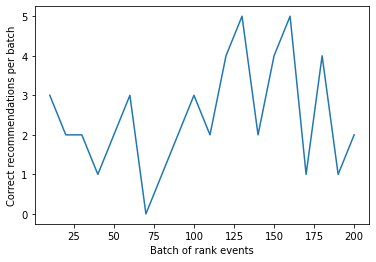

In [29]:
createChart(count,rewards)

In [35]:
#Verify new learning policy and times
get_service_settings() 

-----checking service settings
<Response [200]>
{'name': '83ef3a84273c4a6cae94432a01f87521', 'arguments': '--cb_explore_adf --epsilon 0.2 --dsjson --cb_type mtr --marginal i -q Fj -l 0.1 --l1 0.001 --power_t 0'}
<Response [200]>
{'rewardWaitTime': 'PT5M', 'defaultReward': 0.0, 'rewardAggregation': 'earliest', 'explorationPercentage': 0.2, 'modelExportFrequency': 'PT5M', 'logRetentionDays': 90, 'lastConfigurationEditDate': '2021-08-10T08:06:29', 'learningMode': 'Online'}


In [36]:
# max iterations
num_requests = 200

# check last mod date N% of time - currently 10%
lastModCheck2 = int(num_requests * .10)

jsonTemplate2 = rankactionsjsonobj

# main iterations
[count2, rewards2] = iterations(num_requests, lastModCheck2, jsonTemplate)

2021-08-10 17:07:26.258942
To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Sunny', 'name': 'Bob'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '5270a51493684b40a1955ba232fdb3d6', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': '5270a51493684b40a1955ba232fdb3d6', 'rewardActionId': 'Cold brew'}
2021-08-10 17:07:27.184348
   1 None Bob Sunny Morning Cold brew 0
To:  {'contextFea

From:  {'ranking': [{'id': 'Latte', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}], 'eventId': '87b210d1b083439da69f2a3040e75684', 'rewardActionId': 'Latte'}
2021-08-10 17:07:41.118269
   9 None Alice Rainy Afternoon Latte 0
To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Sunny', 'name': 'Dave'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '7ea58004697f4b81aa388ebd7e02cc8d', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cold brew', 'probab

From:  {'ranking': [{'id': 'Latte', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}], 'eventId': 'c2dd561499d1495eaa4e72b3302611e0', 'rewardActionId': 'Latte'}
2021-08-10 17:07:56.266649
   18 None Alice Sunny Afternoon Latte 0
To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Snowy', 'name': 'Cathy'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '498b3574934344328db93fffc8e50911', 'deferActivation': False}
From:  {'ranking': [{'id': 'Latte', 'probabil

To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Snowy', 'name': 'Dave'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '94db79753543472e9ed866fbcabb09be', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': '94db79753543472e9ed866fbcabb09be', 'rewardActionId': 'Cold brew'}
2021-08-10 17:08:12.470920
   27 None Dave Snowy Afternoon Cold brew 0
To:  {'contextFeatures': [{'timeofday

From:  {'ranking': [{'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'b84b63a2f6f0415191ac08d03ade51c2', 'rewardActionId': 'Cold brew'}
2021-08-10 17:08:25.714547
   35 None Bob Snowy Evening Cold brew 0
To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Snowy', 'name': 'Dave'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '21bc90fb9c4f4e7182b94d5d33974f70', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cold brew', 

To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Sunny', 'name': 'Bob'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': 'fcbfad6134e740bcbaa824e0f80e0c33', 'deferActivation': False}
From:  {'ranking': [{'id': 'Latte', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}], 'eventId': 'fcbfad6134e740bcbaa824e0f80e0c33', 'rewardActionId': 'Latte'}
2021-08-10 17:08:41.520369
   44 None Bob Sunny Morning Latte 0
To:  {'contextFeatures': [{'timeofday': 'Morning', 

From:  {'ranking': [{'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': '69f28ae632fb42b9b8d0416de2446bc5', 'rewardActionId': 'Cold brew'}
2021-08-10 17:08:55.111313
   52 None Bob Rainy Morning Cold brew 0
To:  {'contextFeatures': [{'timeofday': 'Evening', 'weather': 'Sunny', 'name': 'Bob'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '63860410d35749738643d396cdcfc599', 'deferActivation': False}
From:  {'ranking': [{'id': 'Iced mocha', 'p

From:  {'ranking': [{'id': 'Latte', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}], 'eventId': '8a07557e6f2c4d79ae8c038ef776d5f4', 'rewardActionId': 'Latte'}
2021-08-10 17:09:11.299384
   61 None Alice Rainy Evening Latte 1
To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Sunny', 'name': 'Bob'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '53f9eb8a93ed494b88257a96afb73a79', 'deferActivation': False}
From:  {'ranking': [{'id': 'Latte', 'probabilit

From:  {'ranking': [{'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'f6fa637559f94f099b68579c2760a6be', 'rewardActionId': 'Iced mocha'}
2021-08-10 17:09:26.631914
   70 None Bob Sunny Evening Iced mocha 0
To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Rainy', 'name': 'Dave'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '68281b9b85b94992a857b47008fe37b1', 'deferActivation': False}
From:  {'ranking': [{'id': 'Latte', 'p

From:  {'ranking': [{'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': '4dfa95636f63423582a35b5ba94e9fd2', 'rewardActionId': 'Iced mocha'}
2021-08-10 17:09:42.023492
   79 None Bob Rainy Evening Iced mocha 0
To:  {'contextFeatures': [{'timeofday': 'Evening', 'weather': 'Sunny', 'name': 'Alice'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': 'cad1b2f9caa7460683baeb6de77e8c2f', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cappucino',

To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Rainy', 'name': 'Cathy'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': 'a30f6cb39b9844afbf09679a28d96b82', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'a30f6cb39b9844afbf09679a28d96b82', 'rewardActionId': 'Cold brew'}
2021-08-10 17:09:58.003478
   88 None Cathy Rainy Morning Cold brew 0
To:  {'contextFeatures': [{'timeofday':

From:  {'ranking': [{'id': 'Latte', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}], 'eventId': 'c7ec64afa7bf4244a7e1b73273898b0c', 'rewardActionId': 'Latte'}
2021-08-10 17:10:11.290756
   96 None Dave Snowy Evening Latte 0
To:  {'contextFeatures': [{'timeofday': 'Evening', 'weather': 'Rainy', 'name': 'Cathy'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '15b22ee1c23549d99fe3f656499e43cf', 'deferActivation': False}
From:  {'ranking': [{'id': 'Iced mocha', 'probab

From:  {'ranking': [{'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': '92808f54fe324bb3a5cf479ccd745e73', 'rewardActionId': 'Cold brew'}
2021-08-10 17:10:26.843036
   105 None Bob Sunny Afternoon Cold brew 0
To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Snowy', 'name': 'Cathy'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '1a46abfc7353454caa18f4bf4c296541', 'deferActivation': False}
From:  {'ranking': [{'id': 'Iced moc

From:  {'ranking': [{'id': 'Cappucino', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'df98934c52dc40fd97059fc3bf6f740a', 'rewardActionId': 'Cappucino'}
2021-08-10 17:10:41.815243
   114 None Dave Snowy Morning Cappucino 1
To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Rainy', 'name': 'Dave'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '11edc0c6e063465ca5e4340e6e0ac472', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cold brew'

To:  {'contextFeatures': [{'timeofday': 'Evening', 'weather': 'Sunny', 'name': 'Dave'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '0ad0cf19dd25477fa06e9af8f44c8a4d', 'deferActivation': False}
From:  {'ranking': [{'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': '0ad0cf19dd25477fa06e9af8f44c8a4d', 'rewardActionId': 'Iced mocha'}
2021-08-10 17:10:58.109215
   123 None Dave Sunny Evening Iced mocha 1
To:  {'contextFeatures': [{'timeofday'

From:  {'ranking': [{'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'e6b2280d93df472292b538bc3a6cb262', 'rewardActionId': 'Iced mocha'}
2021-08-10 17:11:11.915643
   131 None Dave Rainy Afternoon Iced mocha 0
To:  {'contextFeatures': [{'timeofday': 'Evening', 'weather': 'Sunny', 'name': 'Bob'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '441105c0ba404df2b1b79851b0e28d43', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cold brew

From:  {'ranking': [{'id': 'Cappucino', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': '50e1504549ea4d95849d597aab2be46a', 'rewardActionId': 'Cappucino'}
2021-08-10 17:11:27.080417
   140 None Alice Sunny Evening Cappucino 0
**** 10% of loop found
-----checking model
<Response [200]>
{'creationTime': '2021-08-09T23:03:09+00:00', 'lastModifiedTime': '2021-08-10T08:06:30+00:00'}
-----model updated: "2021-08-10T08:06:30+00:00"
To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Snowy', 'name': 'Cathy'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'typ

To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Snowy', 'name': 'Cathy'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '2c3016b9d94f4ca1a5ed8924ca4f81b6', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cappucino', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': '2c3016b9d94f4ca1a5ed8924ca4f81b6', 'rewardActionId': 'Cappucino'}
2021-08-10 17:11:43.075575
   149 None Cathy Snowy Morning Cappucino 0
To:  {'contextFeatures': [{'timeofday'

From:  {'ranking': [{'id': 'Cappucino', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': '7d255830de784a70a672e4218b4cc389', 'rewardActionId': 'Cappucino'}
2021-08-10 17:11:56.457423
   157 None Alice Rainy Afternoon Cappucino 1
To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Rainy', 'name': 'Bob'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '1b43f41f79064661a1ceee6571497503', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cold bre

To:  {'contextFeatures': [{'timeofday': 'Evening', 'weather': 'Rainy', 'name': 'Dave'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '4ea780c651d64cc599b8320d08dc805d', 'deferActivation': False}
From:  {'ranking': [{'id': 'Latte', 'probability': 0.25}, {'id': 'Cold brew', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}], 'eventId': '4ea780c651d64cc599b8320d08dc805d', 'rewardActionId': 'Latte'}
2021-08-10 17:12:12.364067
   166 None Dave Rainy Evening Latte 1
To:  {'contextFeatures': [{'timeofday': 'Morning

From:  {'ranking': [{'id': 'Cold brew', 'probability': 0.25}, {'id': 'Cappucino', 'probability': 0.25}, {'id': 'Iced mocha', 'probability': 0.25}, {'id': 'Latte', 'probability': 0.25}], 'eventId': 'ce4d828a25a34075a7801718cd4375e0', 'rewardActionId': 'Cold brew'}
2021-08-10 17:12:25.440280
   174 None Dave Snowy Evening Cold brew 0
To:  {'contextFeatures': [{'timeofday': 'Afternoon', 'weather': 'Sunny', 'name': 'Cathy'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '6216e21da0934fd5b59dbf61ac537f0c', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cappucino

To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Sunny', 'name': 'Alice'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '9eb7ab74236d46a1a8a257eb0f5e2a3d', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cold brew', 'probability': 0.05}, {'id': 'Cappucino', 'probability': 0.85}, {'id': 'Latte', 'probability': 0.05}, {'id': 'Iced mocha', 'probability': 0.05}], 'eventId': '9eb7ab74236d46a1a8a257eb0f5e2a3d', 'rewardActionId': 'Cold brew'}
2021-08-10 17:12:41.879761
   183 None Alice Sunny Morning Cold brew 1
To:  {'contextFeatures': [{'timeofday'

From:  {'ranking': [{'id': 'Latte', 'probability': 0.05}, {'id': 'Cold brew', 'probability': 0.05}, {'id': 'Iced mocha', 'probability': 0.05}, {'id': 'Cappucino', 'probability': 0.85}], 'eventId': 'dd203739380943c591de6ceb0429794b', 'rewardActionId': 'Latte'}
2021-08-10 17:12:55.322590
   191 None Alice Sunny Evening Latte 0
To:  {'contextFeatures': [{'timeofday': 'Evening', 'weather': 'Sunny', 'name': 'Alice'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '58814c69fb024089851df494119476b7', 'deferActivation': False}
From:  {'ranking': [{'id': 'Cappucino', 'proba

From:  {'ranking': [{'id': 'Cappucino', 'probability': 0.85}, {'id': 'Iced mocha', 'probability': 0.05}, {'id': 'Cold brew', 'probability': 0.05}, {'id': 'Latte', 'probability': 0.05}], 'eventId': '52085260b0b94592a32fbe6ee9fffcaf', 'rewardActionId': 'Cappucino'}
2021-08-10 17:13:10.416707
   200 None Alice Snowy Afternoon Cappucino 1
**** 10% of loop found
-----checking model
<Response [200]>
{'creationTime': '2021-08-09T23:03:09+00:00', 'lastModifiedTime': '2021-08-10T08:11:45+00:00'}
-----model updated: "2021-08-10T08:11:45+00:00"
2021-08-10 17:13:12.178760


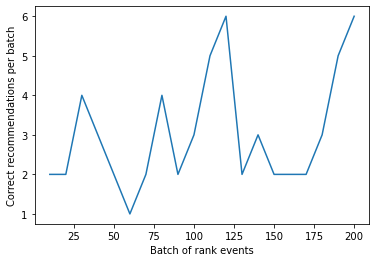

In [37]:
createChart(count2,rewards2)